In [2]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.freesurfer.utils import MakeAverageSubject
%matplotlib inline

Runs freesurfer's recon-all

In [7]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'scripts/sub_cb_mappings.txt'
os.chdir(home_dir)
subjects_dir = abspath('data/freesurfer/')
if not os.path.exists(subjects_dir):
    os.mkdir(subjects_dir)
    
#get subject list
sub_list = []
with open(subj_file) as f:
    for line in f:
        (key,val) = line.strip().split(' ') 
        sub_id = 'fd_' + key
        if not os.path.exists(abspath('data/' + sub_id +'/snapshots')): #if reconall hasnt been run
            sub_list.append(sub_id)

In [15]:
#initialize workflow
wf = Workflow('freesurfer_recon')
wf.base_dir = abspath(home_dir)

In [16]:
#get data using datagrabber
##set up data grabber
ds = Node(DataGrabber(infields=['subject_id','task_id','run_id'],outfields =['func','anat']),
         name = 'datasource')
ds.inputs.base_directory = abspath(home_dir + '/data/')
ds.inputs.template = '*'
# ds.inputs.template_args = {'func': [['subject_id','task_id','run_id']], 'anat':[['subject_id']]}
# ds.inputs.field_template = {'func': '%s/func/%s/run_%s.nii.gz' ,
#                       'anat': '%s/anat/T1w_Whole_brain_1mm.nii.gz'}
ds.inputs.template_args = {'anat':[['subject_id']]}
ds.inputs.field_template = {'anat': '%s/anat/T1w_Whole_brain_1mm.nii.gz'}
ds.inputs.sort_filelist = True

ds.inputs.subject_id = sub_list
ds.inputs.task_id = '*'
ds.inputs.run_id = '*'
#print ds.run().outputs

In [17]:
#set up recon node
recon_all = MapNode(interface = ReconAll(), name = 'recon_all',iterfield = ['subject_id','T1_files'])
recon_all.inputs.subject_id  = sub_list
recon_all.inputs.subjects_dir = subjects_dir
wf.connect(ds,'anat',recon_all,'T1_files')
print recon_all.inputs


T1_files = <undefined>
T2_file = <undefined>
args = <undefined>
directive = all
environ = {}
flags = <undefined>
hemi = <undefined>
ignore_exception = False
openmp = <undefined>
subject_id = ['fd_119', 'fd_120', 'fd_122', 'fd_123', 'fd_124', 'fd_126', 'fd_127', 'fd_128', 'fd_129', 'fd_130']
subjects_dir = /data/home/iballard/fd/data/freesurfer
terminal_output = stream



INFO:workflow:Converting dotfile: /data/home/iballard/fd/freesurfer_recon/workflow_recon-all_graph.dot to png format


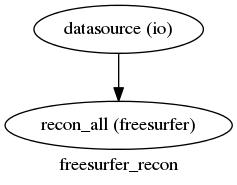

In [18]:
#visualize workflow
wf.write_graph('workflow_recon-all_graph.dot')
Image(filename = home_dir + 'freesurfer_recon/workflow_recon-all_graph.dot.png' )

In [19]:
wf.run(plugin = 'MultiProc')

INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running in parallel.
INFO:workflow:Submitting 1 jobs
INFO:workflow:Executing: datasource ID: 0
INFO:workflow:[Job finished] jobname: datasource jobid: 0
INFO:workflow:Executing node datasource in dir: /data/home/iballard/fd/freesurfer_recon/datasource
INFO:workflow:Submitting 1 jobs
INFO:workflow:Adding 10 jobs for mapnode recon_all
INFO:workflow:Submitting 10 jobs
INFO:workflow:Executing: _recon_all0 ID: 2
INFO:workflow:Executing: _recon_all1 ID: 3
INFO:workflow:Executing: _recon_all2 ID: 4
INFO:workflow:Executing: _recon_all3 ID: 5
INFO:workflow:Executing: _recon_all4 ID: 6
INFO:workflow:Executing: _recon_all5 ID: 7
INFO:workflow:Executing: _recon_all6 ID: 8
INFO:workflow:Executing node _recon_all0 in dir: /data/home/iballard/fd/freesurfer_recon/recon_all/mapflow/_recon_all0
INFO:workflow:Executing node _recon_all1 in dir: /data/home/iballard/fd/freesurfer_recon/recon_all/mapflow/_recon_all1
INFO:workflow:Executing: _recon

INFO:interface:stdout 2015-05-03T01:58:24.658312:  538    392    915  2.052 0.697     0.163     0.056       10     1.6  S_orbital_lateral
INFO:interface:stdout 2015-05-03T01:58:24.658312:  712    529   1297  2.646 0.571     0.114     0.026        4     0.7  S_orbital_med-olfact
INFO:interface:stdout 2015-05-03T01:58:24.658312: 1246    874   2387  2.523 0.767     0.149     0.054       16     2.8  S_orbital-H_Shaped
INFO:interface:stdout 2015-05-03T01:58:24.658312: 2129   1404   2568  2.003 0.586     0.120     0.031       18     2.8  S_parieto_occipital
INFO:interface:stdout 2015-05-03T01:58:24.658312: 1725   1084   2156  2.426 0.773     0.129     0.040       23     2.8  S_pericallosal
INFO:interface:stdout 2015-05-03T01:58:24.658312: 2434   1625   3170  2.054 0.500     0.119     0.032       20     3.2  S_postcentral
INFO:interface:stdout 2015-05-03T01:58:24.658312: 1727   1168   2502  2.287 0.404     0.117     0.029       15     2.2  S_precentral-inf-part
INFO:interface:stdout 2015-05-0

In [12]:
##fix directory structure. For some reason ipython insists on making a new directory for freesurfer outputs,
#but lyman wants them in the subject folder
for sub in sub_list:
    freesurfer_dir = home_dir + '/data/freesurfer/' + sub
    sub_dir = home_dir + '/data/' + sub +'/'
    cmd = 'mv ' + freesurfer_dir + '/* ' + sub_dir
    os.system(cmd)
    os.rmdir(freesurfer_dir)
